# Intro to NN and Backpropogation

Notes taken on Andrej Karpathy's Nueral Network intro video 1

### Background on Derivatives

In [90]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [51]:
def f(x):
    return 3*x**2 - 4*x + 5

In [52]:
f(3)

20

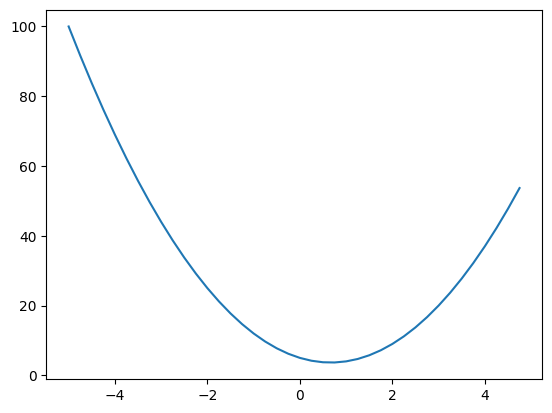

In [53]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

### Derivative of a function with one input

**What is the derivative at different points x?**

- how does the slope at a point (x) change with a slight (h) change to x?

In [54]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

at 3, the slope is 14 using the derivative equation

In [55]:
h = 0.001
x = -3.0
(f(x+h) - f(x))/h

-21.996999999998934

### Derivatives of a function with multiple inputs

In [56]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c # function d that gives an output from a, b, c

In [57]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0


d1 = a*b + c
a += h # we expect the slope to decrease as a grows because a is multiplied by a negative number (b)
d2 = a*b + c
print("with respect to a")
print("d1: ", d1)
print("d2: ", d2)
print("slope:", (d2-d1)/h)

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h # we expect the slope to increase
d2 = a*b + c
print("with respect to b")
print("d1: ", d1)
print("d2: ", d2)
print("slope:", (d2-d1)/h)

with respect to a
d1:  4.0
d2:  3.999699999999999
slope: -3.000000000010772
with respect to b
d1:  4.0
d2:  4.0002
slope: 2.0000000000042206


- where the slope is the amount that the function d will scale with respect to the variable being increased

## Building Micrograd

### Value Object

- takes a single scalar object which it wraps

In [58]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

- we need to keep pointers (connective tissue) about which values produce which other values
    - this is why we add children, prev

In [59]:
d._prev

{Value(data=-6.0), Value(data=10)}

In [60]:
d._op

'+'

Code to help us visualize output from function

In [61]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

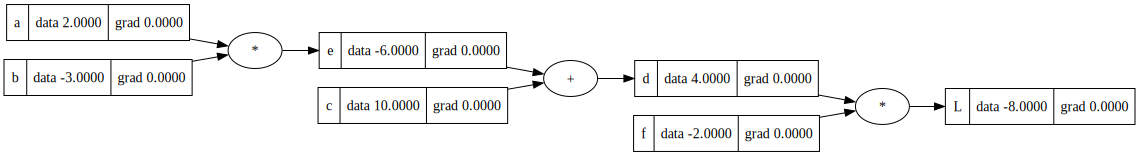

In [62]:
draw_dot(L)

- so far we have built out a mathematical expression using forward pass
    - multiple inputs that go into a mathematical expression and get a single output

- what we want to do next is *backpropogation*
- "calculate gradient along all intermediate values"
- compute derivative of every single value with respect to the final output (L)
    - L is essentially a loss function
    - some of these leaf nodes will be weights, others data
    - interested in knowing the derivative of the loss function with respect to each intermediate value

dL/dc = ?

We need to use the **chain rule**

in this case, if z depends on y, and y depends on x, then z depends on x as well.

Mathematically: (dz/dx) = (dz/dy) * (dy/dx)

Gradient of L is 1
L = d * f

dL / dd = 1 * f = -2
dL / df = 1 * d = 4

In [63]:
L.grad = 1
d.grad = -2
f.grad = 4

Now for c and e
d = c + e

dd / dc = 1
dd / de = 1

when we find dL / dc, we need to use chain rule

so...

dL / dc = (dL / dd) * (dd / dc) = -2 * 1 = -2
dL / de = -2

In [64]:
c.grad = -2
e.grad = -2

finally, we do this for a and b

e = a*b
de / da = b = -3
de / db = a = 2

dL / da = (dL / de) * (de / da) = -2 * -3 = 6
dL / db = (dL / de) * (de / db) = -2 * 2 = -4

In [65]:
a.grad = 6
b.grad = -4

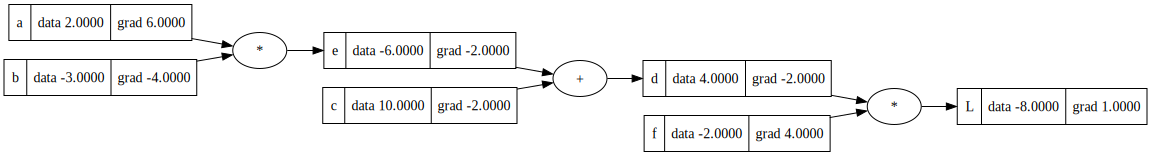

In [66]:
draw_dot(L)

In [67]:
def ex():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='l')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='l')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

ex()

6.000000000000227


This is the derivative of L with respect to a

**This is manual backpropogation - we iterate backwards through the nodes and find each derivative with respect to L by recursively applying local derivatives through the chain rule**

### More Complex backpropogation example

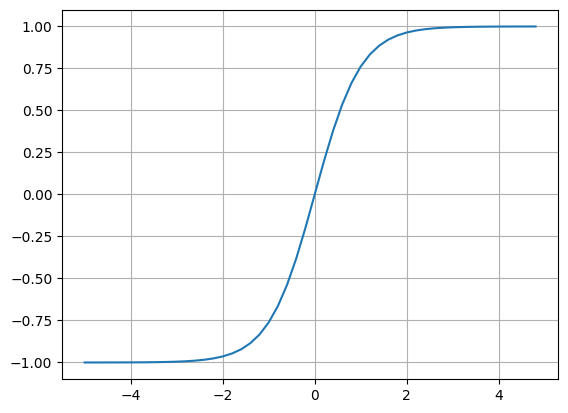

In [68]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [69]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

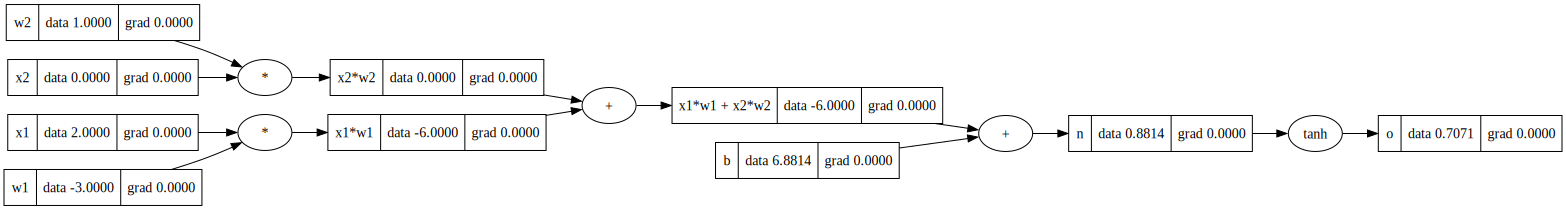

In [70]:
draw_dot(o)

Backpropogate and get partial derivatives again:
- we have to backpropogate through the tanh function too!
- for tanh, we (don't remember) know from calculus that the derivative of tanh(x) = 1 - tanh(x)^2

In [71]:
# o.grad = 1.0

# #o = tanh(n)
# # do/dn = 1 - tanh(n)**2
# n.grad = 1 - o.data**2

# x1w1x2w2.grad = .5 # remember that addition just takes the derivative of the next output node
# b.grad = .5

# x1w1.grad = .5
# x2w2.grad = .5

x2 gradient will be dx / d(x2w2) * d(x2w2) / dL => (dx/d(x2w2))*(.5) => w2*.5 = 1*.5 = .5

In [72]:
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# w1.grad = x1.data * x1w1.grad
# x1.grad = w1.data * x1w1.grad

In [73]:
# o.grad = 1.0
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

# draw_dot(o)

We need to use a *Topological Sort* to order nodes from left to right such that the backpropogation happens in the correct order
- i.e. o -> n -> x1w1x2w2.... and so on

*Defined in backward() function above*

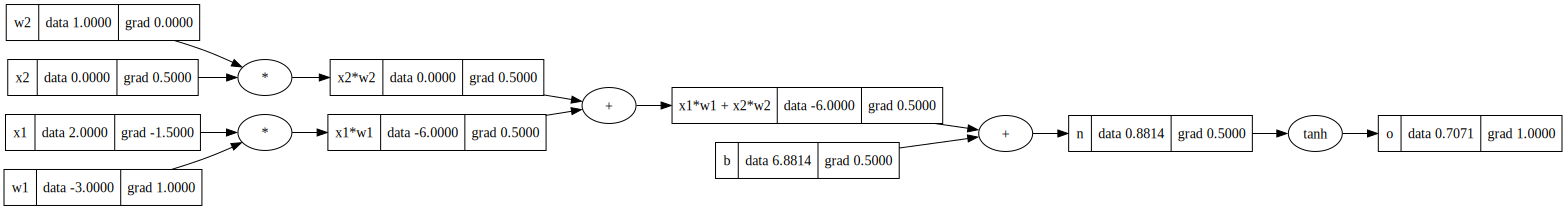

In [74]:
o.backward()
draw_dot(o)

implementing tan(h) with other ooperations now:

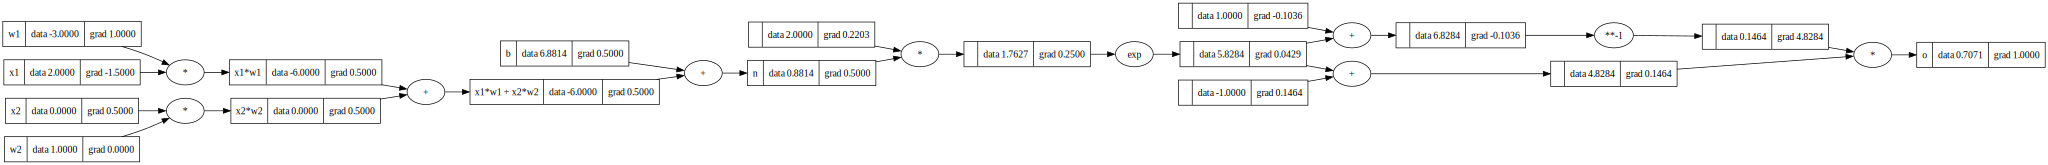

In [75]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

## Now Using PyTorch!

**Tensors**: N-dimensional arrays of scalars

In [79]:
import torch

In [81]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True # single value tensor, need to specify that these nodes require gradients
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

In [83]:
print(o.data.item())
o.backward()

0.7071066904050358


In [87]:
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

-1.5000003851533106
1.0000002567688737
0.5000001283844369
0.0


In [84]:
x1.dtype # double precision

torch.float64

PyTorch allows us to make these tensor objects (single element) like we created manually above, but is more efficient because we can do lots of options in parallel on these tensors

## Building out a Neural Net

In [158]:
class Neuron:
    # match the API of pytorch with custom functions
    def __init__(self, nin): # number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1)) # bias to control "trigger-happiness" of the neuron

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout): # nout is number of neurons in a layer
        self.neurons = [Neuron(nin) for _ in range(nout)] # literally just a list of Neuron objects

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts): # nouts is the number of neurons in every layer (list)
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.8051151738101368)

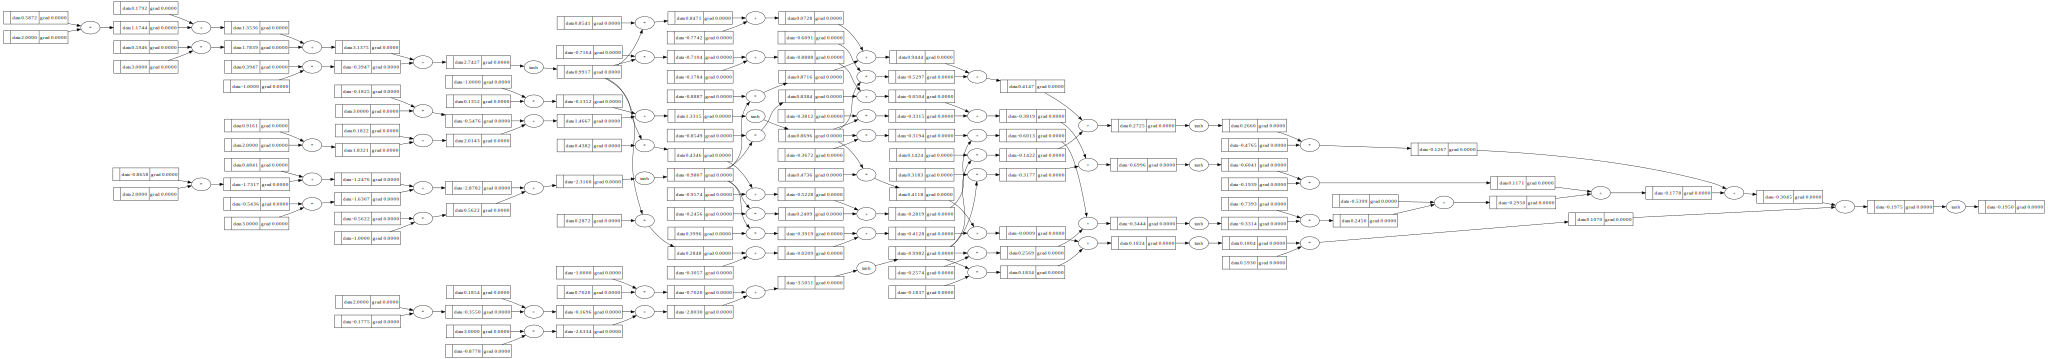

In [115]:
draw_dot(n(x))

- Already a very big MLP to try to examine, but as we've learned we can theoretically backpropogate and get the partial derivatives of each of these inputs

In [157]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [147]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.554051498400156),
 Value(data=-0.47511228326784516),
 Value(data=-0.637223848334747),
 Value(data=-0.502967178775156)]

**Loss**: a single number that measures the total performance of our neural net
- allows us to tune our model and improve performance
- want to minimize the loss

here we use mean squared error loss

In [156]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.8220106505836877e-05)

In [143]:
loss.backward()

In [133]:
n.layers[0].neurons[0].w[0].grad

0.02163052165836131

Okay now this shit is cool- when we backpropogate with the loss, we get the gradient for each neuron in our MLP. For example, if we find the partial derivative of a weight to be -0.3, we know that increasing this weight will decrease the loss! This is the first step to allowing us to minimize our loss. 

- We do need to remember that although the input data also has gradients, these are not as helpful to us as we assume that the input data cannot (should not) change

In [ ]:
draw_dot(loss)

### Doing gradient descent manually to train the network

 for all of our 41 parameters, we want to change the weights *slightly* based on the gradient information

In [137]:
n.layers[0].neurons[0].w[0].data

-0.2519321289108108

In [145]:
for p in n.parameters():
    p.data += -0.01 * p.grad # We want to decrease these parameters to minimize loss, step size here

In [139]:
n.layers[0].neurons[0].w[0].data

-0.2521484341273944

If we recalculate the loss after getting our y predictions again, we can see that it decreases slightly.

- need to be careful of step size to minimize loss without exploding it!

This process of iteratively doing forward pass, backward pass, and updating is *Gradient Descent*!

Let's automate this process a little bit

In [159]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters(): # need to reset all the gradients to 0 after each pass! Other will continually sum
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    

0 9.693197305425606
1 6.408626285472824
2 5.285720382260343
3 4.479501812630246
4 4.198723920710495
5 3.9883267224101324
6 3.7410696479124366
7 3.258203810800081
8 1.8398483216620156
9 0.2897038380935403
10 0.19341147088768512
11 0.15075975022931518
12 0.12424173549887024
13 0.10582955003609926
14 0.09220490896009309
15 0.08168269358407565
16 0.07329921693075778
17 0.06645780572190764
18 0.06076711711466582
19 0.055958912910294395


In [160]:
ypred

[Value(data=0.9265961352409418),
 Value(data=-0.890069264273814),
 Value(data=-0.840452489672089),
 Value(data=0.8858482990070106)]

### Conclusions

Neural Nets are mathematical expressions that take input as the data and the weights/parameters of the neural net.

Mathematical expression as forward pass, and then loss function to measure accuracy of the predictions.

We want to minimize loss, so we use backpropogation to get the gradient, then tune local parameters to decrease loss based on each gradient.

We iterate this process multiple times, called gradient descent.